<a href="https://colab.research.google.com/github/LohithBlaze/HaystackAdventOfAI/blob/master/Copy_of_Advent_of_Haystack_Enhancing_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advent of Haystack: Day 1
_Make a copy of this Colab to start!_

In this first challenge, we are going to build a pipeline that answers questions based on the contents of a URL. The given pipeline works as it, but your task is to complete the connnections and add the **other required two components**👇

**You should complete the missing sections in step 3, 4 and 5**

### Initial Components to use:
- [`LinkContentFetcher`](https://docs.haystack.deepset.ai/docs/linkcontentfetcher) for using the contents of several URLs in your pipeline
- [`HTMLToDocument`](https://docs.haystack.deepset.ai/docs/htmltodocument) for converting the HTML files into documents.
- [`PromptBuilder`](https://docs.haystack.deepset.ai/docs/promptbuilder) for creating the prompt
- [`OpenAIGenerator`](https://docs.haystack.deepset.ai/docs/openaigenerator) for generating responses

### 1) Installation

Install `haystack-ai`, `trafilatura` and `sentence-transformers` packages with `pip`:

In [1]:
!pip install haystack-ai trafilatura "sentence-transformers>=3.0.0"
!pip install -q --upgrade openai # not to get the OpenAI proxies error: https://community.openai.com/t/error-with-openai-1-56-0-client-init-got-an-unexpected-keyword-argument-proxies/1040332/2

### (Optional) Change the Logging Level

This way, not only warnings but also information messages are displayed in the console output.

In [31]:
# import logging

# logging.basicConfig(format="%(levelname)s - %(name)s -  %(message)s", level=logging.WARNING)
# logging.getLogger("haystack").setLevel(logging.DEBUG)

import logging
from haystack import tracing
from haystack.tracing.logging_tracer import LoggingTracer

logging.basicConfig(format="%(levelname)s - %(name)s -  %(message)s", level=logging.WARNING)
logging.getLogger("haystack").setLevel(logging.DEBUG)

tracing.tracer.is_content_tracing_enabled = True # to enable tracing/logging content (inputs/outputs)
tracing.enable_tracing(LoggingTracer(tags_color_strings={"haystack.component.input": "\x1b[1;31m", "haystack.component.name": "\x1b[1;34m"}))

### 2) Enter API key for OpenAI
If you will use OpenAI models, save your API key as `OPENAI_API_KEY` environment variable.

In [32]:
from getpass import getpass
import os

os.environ["OPENAI_API_KEY"] = getpass("Enter OpenAI API key:")

Enter OpenAI API key:··········


### 3) Create components

Initialize two components to complete the pipeline.

**Hints**:
* One component is to split the documents into smaller chunks of 10 sentences each.
* As the other component, consider methods or components you can use to filter out irrelevant chunks by ranking before injecting the context into the prompt

In [72]:
from haystack.components.fetchers import LinkContentFetcher
from haystack.components.converters import HTMLToDocument
from haystack.components.builders import PromptBuilder
from haystack.components.generators import OpenAIGenerator
from haystack.components.preprocessors import DocumentSplitter
from haystack.components.rankers import SentenceTransformersDiversityRanker

fetcher = LinkContentFetcher()
converter = HTMLToDocument()
splitter = DocumentSplitter(
    split_by="word",
    split_length=150,
    split_overlap=30
)

ranker = SentenceTransformersDiversityRanker(
    model="sentence-transformers/all-MiniLM-L6-v2",
    top_k=10
)

template = """Given the information below, answer the query. Only use the provided context to generate the answer and output the used document links
            Context:
            {% for document in documents %}
                {{ document.content }}
                URL: {{ document.meta.url }}
            {% endfor %}

            Question: {{ query }}
            Answer:"""

prompt_builder = PromptBuilder(template = template)
generator = OpenAIGenerator(model="gpt-4o-mini") # Feel free to try different models or different providers

### 4) Add them to a Haystack Pipeline

In [73]:
from haystack import Pipeline

pipeline = Pipeline()
pipeline.add_component(name="fetcher", instance=fetcher)
pipeline.add_component(name="converter", instance=converter)
#### ADD MISSING COMPONENTS HERE ####
pipeline.add_component(name="preprocessor", instance=splitter)
pipeline.add_component(name="ranker", instance=ranker)
#####################################
pipeline.add_component(name="prompt_builder", instance=prompt_builder)
pipeline.add_component(name="generator", instance=generator)

DEBUG:haystack.core.pipeline.base:Adding component 'fetcher' (<haystack.components.fetchers.link_content.LinkContentFetcher object at 0x7b802852bcd0>

Inputs:
  - urls: List[str]
Outputs:
  - streams: List[ByteStream])
DEBUG:haystack.core.pipeline.base:Adding component 'converter' (<haystack.components.converters.html.HTMLToDocument object at 0x7b802852bca0>

Inputs:
  - sources: List[Union[str, Path, ByteStream]]
  - meta: Union[Dict[str, Any], List[Dict[str, Any]]]
  - extraction_kwargs: Optional[Dict[str, Any]]
Outputs:
  - documents: List[Document])
DEBUG:haystack.core.pipeline.base:Adding component 'preprocessor' (<haystack.components.preprocessors.document_splitter.DocumentSplitter object at 0x7b802850c040>

Inputs:
  - documents: List[Document]
Outputs:
  - documents: List[Document])
DEBUG:haystack.core.pipeline.base:Adding component 'ranker' (<haystack.components.rankers.sentence_transformers_diversity.SentenceTransformersDiversityRanker object at 0x7b802850d540>

Inputs:
  - q

###5) Connect the components

Complete the pipeline connections to achieve a working pipeline that can be run.

**Note:** Everytime you want to run cell 4 and cell 5, you need to run cell 3 and reinitialize all components

In [74]:
pipeline.connect("fetcher", "converter")
pipeline.connect("converter", "preprocessor")
pipeline.connect("preprocessor", "ranker")
pipeline.connect("ranker", "prompt_builder")
pipeline.connect("prompt_builder", "generator")

DEBUG:haystack.core.pipeline.base:Connecting 'fetcher.streams' to 'converter.sources'
DEBUG:haystack.core.pipeline.base:Connecting 'converter.documents' to 'preprocessor.documents'
DEBUG:haystack.core.pipeline.base:Connecting 'preprocessor.documents' to 'ranker.documents'
DEBUG:haystack.core.pipeline.base:Connecting 'ranker.documents' to 'prompt_builder.documents'
DEBUG:haystack.core.pipeline.base:Connecting 'prompt_builder.prompt' to 'generator.prompt'


🚅 Components
  - fetcher: LinkContentFetcher
  - converter: HTMLToDocument
  - preprocessor: DocumentSplitter
  - ranker: SentenceTransformersDiversityRanker
  - prompt_builder: PromptBuilder
  - generator: OpenAIGenerator
🛤️ Connections
  - fetcher.streams -> converter.sources (List[ByteStream])
  - converter.documents -> preprocessor.documents (List[Document])
  - preprocessor.documents -> ranker.documents (List[Document])
  - ranker.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> generator.prompt (str)

###6) Visualize the Pipeline 🎨

Display the pipeline image with [`show()`](https://docs.haystack.deepset.ai/docs/visualizing-pipelines) method to understand the connections between components

DEBUG:haystack.core.pipeline.draw:Mermaid diagram:

%%{ init: {'theme': 'neutral' } }%%

graph TD;

fetcher["<b>fetcher</b><br><small><i>LinkContentFetcher</i></small>"]:::component -- "streams -> sources<br><small><i>List[ByteStream]</i></small>" --> converter["<b>converter</b><br><small><i>HTMLToDocument<br><br>Optional inputs:<ul style='text-align:left;'><li>meta (Union[Dict[str, Any], List[Dict[str, Any]]])</li><li>extraction_kwargs (Optional[Dict[str, Any]])</li></ul></i></small>"]:::component
converter["<b>converter</b><br><small><i>HTMLToDocument<br><br>Optional inputs:<ul style='text-align:left;'><li>meta (Union[Dict[str, Any], List[Dict[str, Any]]])</li><li>extraction_kwargs (Optional[Dict[str, Any]])</li></ul></i></small>"]:::component -- "documents -> documents<br><small><i>List[Document]</i></small>" --> preprocessor["<b>preprocessor</b><br><small><i>DocumentSplitter</i></small>"]:::component
preprocessor["<b>preprocessor</b><br><small><i>DocumentSplitter</i></small>"]:::co

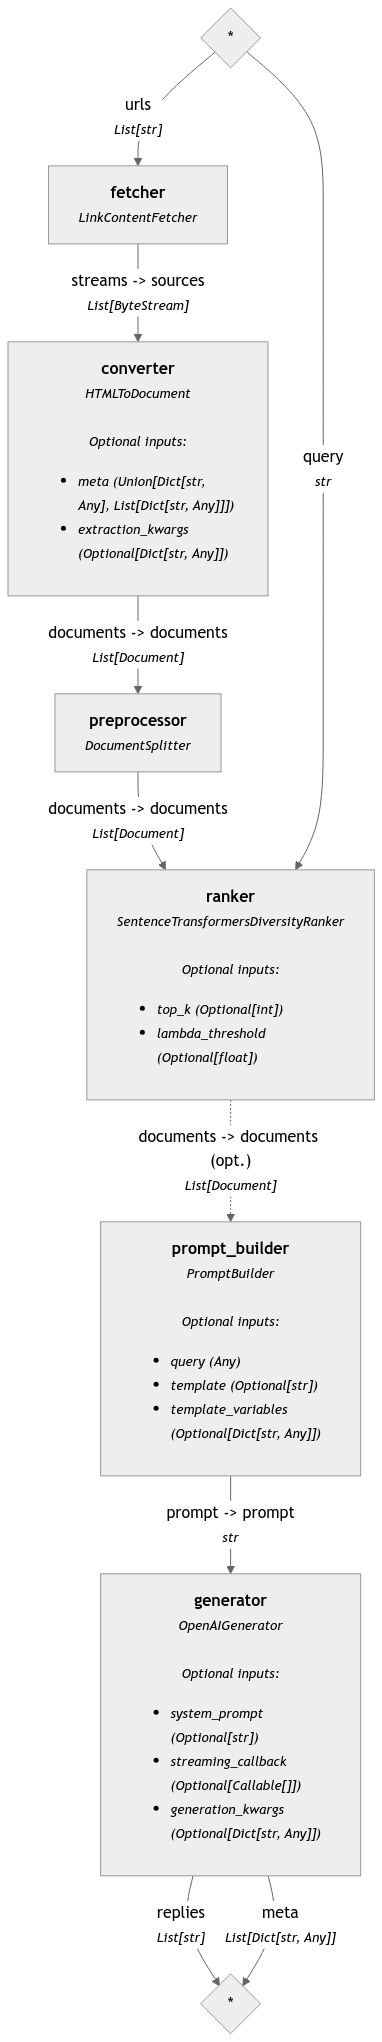

In [75]:
pipeline.show()

###7) Run the Pipeline

Use the URLs below and try the example queries.

In [76]:
urls = ["https://haystack.deepset.ai/blog/extracting-metadata-filter",
        "https://haystack.deepset.ai/blog/query-expansion",
        "https://haystack.deepset.ai/blog/query-decomposition",
        "https://haystack.deepset.ai/cookbook/metadata_enrichment"]

## Example queries you can try
# query = "What is the difference between metadata filtering and metadata enrichment?"
# query = "Which methods can I use to transform query for better retrieval?"
# query = "How can I use metadata to improve retrieval?"
query = "What's preprocessing?" # Should return no answer

## Add parameters
result = pipeline.run(data={"fetcher": {"urls": urls}, "prompt_builder": {"query": query}, "ranker": {"query": query, "top_k": 10}})

INFO:haystack.core.pipeline.base:Warming up component ranker...
INFO:haystack.core.pipeline.pipeline:Running component fetcher
DEBUG:haystack.tracing.logging_tracer:Operation: haystack.component.run
DEBUG:haystack.tracing.logging_tracer:haystack.component.name=fetcher
DEBUG:haystack.tracing.logging_tracer:haystack.component.type=LinkContentFetcher
DEBUG:haystack.tracing.logging_tracer:haystack.component.input_types={'urls': 'list'}
DEBUG:haystack.tracing.logging_tracer:haystack.component.input_spec={'urls': {'type': 'typing.List[str]', 'senders': []}}
DEBUG:haystack.tracing.logging_tracer:haystack.component.output_spec={'streams': {'type': 'typing.List[haystack.dataclasses.byte_stream.ByteStream]', 'receivers': ['converter']}}
DEBUG:haystack.tracing.logging_tracer:haystack.component.input={'urls': ['https://haystack.deepset.ai/blog/extracting-metadata-filter', 'https://haystack.deepset.ai/blog/query-expansion', 'https://haystack.deepset.ai/blog/query-decomposition', 'https://haystack.d

Print the LLM response

In [77]:
print(result['generator']['replies'][0])

Preprocessing refers to the steps taken to prepare data for analysis or processing. In the context of the information given, preprocessing may involve techniques such as data cleaning, transforming data into a desired format, normalizing or scaling values, and enhancing metadata to improve the quality and relevance of the data that is being analyzed or used in retrieval augmented generation (RAG) tasks.

The concept is crucial when working with retrieval systems, as the quality of input data can significantly affect the effectiveness of the retrieval step and, subsequently, the generation step.

**Used Document Links:**
- https://haystack.deepset.ai/blog/query-expansion
- https://haystack.deepset.ai/cookbook/metadata_enrichment


### (Optional) Bonus Task

Try to recreate the same pipeline but this time, use [OpenAIChatGenerator](https://docs.haystack.deepset.ai/docs/openaichatgenerator) and [ChatPromptBuilder](https://docs.haystack.deepset.ai/docs/chatpromptbuilder)

In [88]:
from haystack.components.fetchers import LinkContentFetcher
from haystack.components.converters import HTMLToDocument
from haystack.components.builders import PromptBuilder
from haystack.components.generators.chat import OpenAIChatGenerator
from haystack.components.preprocessors import DocumentSplitter
from haystack.components.rankers import SentenceTransformersDiversityRanker
from haystack.components.builders import ChatPromptBuilder
from haystack.dataclasses import ChatMessage

fetcher = LinkContentFetcher()
converter = HTMLToDocument()
splitter = DocumentSplitter(
    split_by="word",
    split_length=150,
    split_overlap=30
)

ranker = SentenceTransformersDiversityRanker(
    model="sentence-transformers/all-MiniLM-L6-v2",
    top_k=10
)

user_template = """Given the information below, answer the query. Only use the provided context to generate the answer and output the used document links
            Context:
            {% for document in documents %}
                {{ document.content }}
                URL: {{ document.meta.url }}
            {% endfor %}

            Question: {{ query }}
            Answer:"""

system_message = """You are a technical expert. Use only the provided content and source URLs to answer questions. Don't use your own knowledge.
Do not add any extra information or search the web.
Keep your answers clear, accurate, and to the point, including the document links you used.
If the documents don't have the answer, say "no answer"
"""

messages = [
    ChatMessage.from_system(system_message),
    ChatMessage.from_user(user_template)
]

chat_prompt_builder = ChatPromptBuilder(template=messages)
generator = OpenAIChatGenerator(model="gpt-4o-mini") # Feel free to try different models or different providers

In [89]:
from haystack import Pipeline

pipeline = Pipeline()
pipeline.add_component(name="fetcher", instance=fetcher)
pipeline.add_component(name="converter", instance=converter)
#### ADD MISSING COMPONENTS HERE ####
pipeline.add_component(name="preprocessor", instance=splitter)
pipeline.add_component(name="ranker", instance=ranker)
#####################################
pipeline.add_component(name="chat_prompt_builder", instance=chat_prompt_builder)
pipeline.add_component(name="generator", instance=generator)

DEBUG:haystack.core.pipeline.base:Adding component 'fetcher' (<haystack.components.fetchers.link_content.LinkContentFetcher object at 0x7b80286d2bf0>

Inputs:
  - urls: List[str]
Outputs:
  - streams: List[ByteStream])
DEBUG:haystack.core.pipeline.base:Adding component 'converter' (<haystack.components.converters.html.HTMLToDocument object at 0x7b80286d14e0>

Inputs:
  - sources: List[Union[str, Path, ByteStream]]
  - meta: Union[Dict[str, Any], List[Dict[str, Any]]]
  - extraction_kwargs: Optional[Dict[str, Any]]
Outputs:
  - documents: List[Document])
DEBUG:haystack.core.pipeline.base:Adding component 'preprocessor' (<haystack.components.preprocessors.document_splitter.DocumentSplitter object at 0x7b80286d3dc0>

Inputs:
  - documents: List[Document]
Outputs:
  - documents: List[Document])
DEBUG:haystack.core.pipeline.base:Adding component 'ranker' (<haystack.components.rankers.sentence_transformers_diversity.SentenceTransformersDiversityRanker object at 0x7b80286d2830>

Inputs:
  - q

In [90]:
pipeline.connect("fetcher", "converter")
pipeline.connect("converter", "preprocessor")
pipeline.connect("preprocessor", "ranker")
pipeline.connect("ranker", "chat_prompt_builder")
pipeline.connect("chat_prompt_builder", "generator")

DEBUG:haystack.core.pipeline.base:Connecting 'fetcher.streams' to 'converter.sources'
DEBUG:haystack.core.pipeline.base:Connecting 'converter.documents' to 'preprocessor.documents'
DEBUG:haystack.core.pipeline.base:Connecting 'preprocessor.documents' to 'ranker.documents'
DEBUG:haystack.core.pipeline.base:Connecting 'ranker.documents' to 'chat_prompt_builder.documents'
DEBUG:haystack.core.pipeline.base:Connecting 'chat_prompt_builder.prompt' to 'generator.messages'


🚅 Components
  - fetcher: LinkContentFetcher
  - converter: HTMLToDocument
  - preprocessor: DocumentSplitter
  - ranker: SentenceTransformersDiversityRanker
  - chat_prompt_builder: ChatPromptBuilder
  - generator: OpenAIChatGenerator
🛤️ Connections
  - fetcher.streams -> converter.sources (List[ByteStream])
  - converter.documents -> preprocessor.documents (List[Document])
  - preprocessor.documents -> ranker.documents (List[Document])
  - ranker.documents -> chat_prompt_builder.documents (List[Document])
  - chat_prompt_builder.prompt -> generator.messages (List[ChatMessage])

DEBUG:haystack.core.pipeline.draw:Mermaid diagram:

%%{ init: {'theme': 'neutral' } }%%

graph TD;

fetcher["<b>fetcher</b><br><small><i>LinkContentFetcher</i></small>"]:::component -- "streams -> sources<br><small><i>List[ByteStream]</i></small>" --> converter["<b>converter</b><br><small><i>HTMLToDocument<br><br>Optional inputs:<ul style='text-align:left;'><li>meta (Union[Dict[str, Any], List[Dict[str, Any]]])</li><li>extraction_kwargs (Optional[Dict[str, Any]])</li></ul></i></small>"]:::component
converter["<b>converter</b><br><small><i>HTMLToDocument<br><br>Optional inputs:<ul style='text-align:left;'><li>meta (Union[Dict[str, Any], List[Dict[str, Any]]])</li><li>extraction_kwargs (Optional[Dict[str, Any]])</li></ul></i></small>"]:::component -- "documents -> documents<br><small><i>List[Document]</i></small>" --> preprocessor["<b>preprocessor</b><br><small><i>DocumentSplitter</i></small>"]:::component
preprocessor["<b>preprocessor</b><br><small><i>DocumentSplitter</i></small>"]:::co

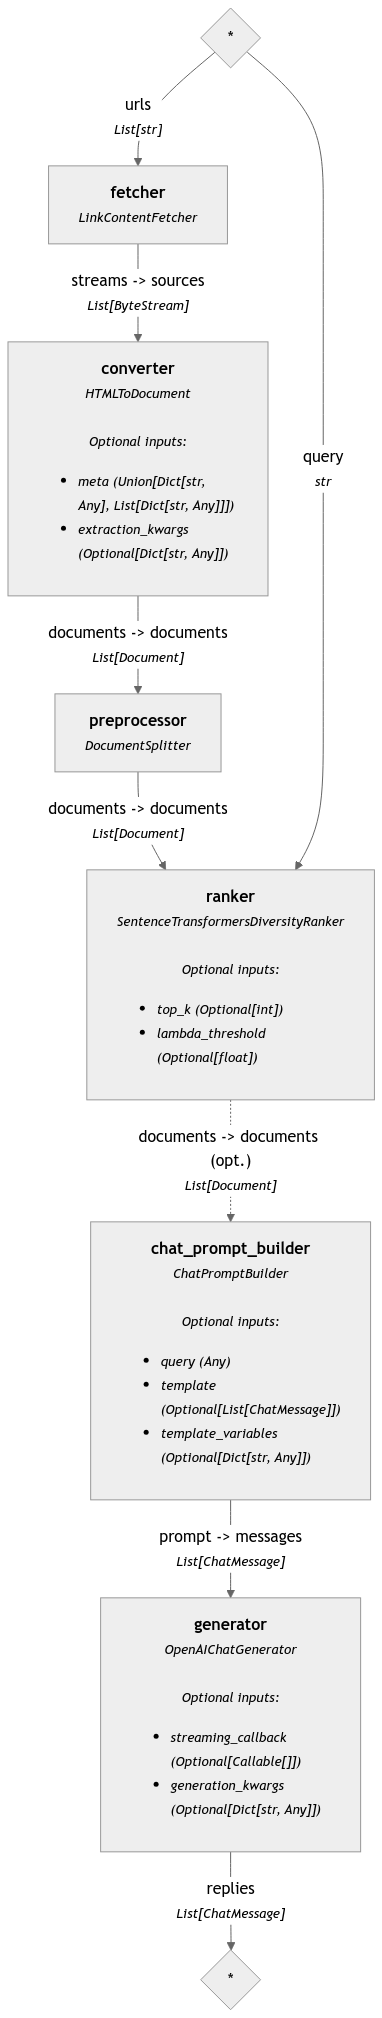

In [91]:
pipeline.show()

In [93]:
urls = ["https://haystack.deepset.ai/blog/extracting-metadata-filter",
        "https://haystack.deepset.ai/blog/query-expansion",
        "https://haystack.deepset.ai/blog/query-decomposition",
        "https://haystack.deepset.ai/cookbook/metadata_enrichment"]

## Example queries you can try
# query = "What is the difference between metadata filtering and metadata enrichment?"
# query = "Which methods can I use to transform query for better retrieval?"
# query = "How can I use metadata to improve retrieval?"
query = "What's preprocessing?" # Should return no answer

## Add parameters
result = pipeline.run(data={"fetcher": {"urls": urls}, "chat_prompt_builder": {"query": query}, "ranker": {"query": query, "top_k": 10}})

INFO:haystack.core.pipeline.base:Warming up component ranker...
INFO:haystack.core.pipeline.pipeline:Running component fetcher
DEBUG:haystack.tracing.logging_tracer:Operation: haystack.component.run
DEBUG:haystack.tracing.logging_tracer:haystack.component.name=fetcher
DEBUG:haystack.tracing.logging_tracer:haystack.component.type=LinkContentFetcher
DEBUG:haystack.tracing.logging_tracer:haystack.component.input_types={'urls': 'list'}
DEBUG:haystack.tracing.logging_tracer:haystack.component.input_spec={'urls': {'type': 'typing.List[str]', 'senders': []}}
DEBUG:haystack.tracing.logging_tracer:haystack.component.output_spec={'streams': {'type': 'typing.List[haystack.dataclasses.byte_stream.ByteStream]', 'receivers': ['converter']}}
DEBUG:haystack.tracing.logging_tracer:haystack.component.input={'urls': ['https://haystack.deepset.ai/blog/extracting-metadata-filter', 'https://haystack.deepset.ai/blog/query-expansion', 'https://haystack.deepset.ai/blog/query-decomposition', 'https://haystack.d

In [94]:
print(result['generator']['replies'][0])

ChatMessage(content='no answer', role=<ChatRole.ASSISTANT: 'assistant'>, name=None, meta={'model': 'gpt-4o-mini-2024-07-18', 'index': 0, 'finish_reason': 'stop', 'usage': {'completion_tokens': 2, 'prompt_tokens': 3932, 'total_tokens': 3934, 'completion_tokens_details': CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), 'prompt_tokens_details': PromptTokensDetails(audio_tokens=0, cached_tokens=0)}})
